In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '6'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_DO_BN(conv_num=1):
    init_channel = 64
    
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=init_channel, strides=1, 
                      padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=int(init_channel/(2**int((i+1)/3))), 
                          strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_DO_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 64)         256       
_________________________________________________________________
activation (Activation)      (None, 16000, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024000)           0         
_________________________________________________________________
dropout (Dropout)            (None, 1024000)           0         
_________________________________________________________________
dense (Dense)        

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_10 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_10 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_11 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_11 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 5333, 64)          0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_28 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_28 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_28 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_29 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_29 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 5333, 64)          0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1614 - acc: 0.3296
Epoch 00001: val_loss improved from inf to 1.62868, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_DO_BN_4_conv_checkpoint/001-1.6287.hdf5
36805/36805 [==============================] - 86s 2ms/sample - loss: 2.1612 - acc: 0.3296 - val_loss: 1.6287 - val_acc: 0.4771
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4707 - acc: 0.5331
Epoch 00002: val_loss improved from 1.62868 to 1.30408, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_DO_BN_4_conv_checkpoint/002-1.3041.hdf5
36805/36805 [==============================] - 83s 2ms/sample - loss: 1.4708 - acc: 0.5331 - val_loss: 1.3041 - val_acc: 0.5903
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2576 - acc: 0.6054
Epoch 00003: val_loss improved from 1.30408 to 1.08315, savin

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3999 - acc: 0.8712
Epoch 00026: val_loss did not improve from 0.80977
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.4000 - acc: 0.8711 - val_loss: 0.8424 - val_acc: 0.7629
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3919 - acc: 0.8743
Epoch 00027: val_loss did not improve from 0.80977
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.3920 - acc: 0.8743 - val_loss: 0.9036 - val_acc: 0.7517
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3716 - acc: 0.8813
Epoch 00028: val_loss did not improve from 0.80977
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.3716 - acc: 0.8812 - val_loss: 1.1530 - val_acc: 0.6944
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3616 - acc: 0.8840
Epoch 00029: val_loss did not improve from 0.80977
36805/36805 [===========

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2116 - acc: 0.9307
Epoch 00056: val_loss did not improve from 0.80977
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.2119 - acc: 0.9307 - val_loss: 0.9014 - val_acc: 0.7782
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2231 - acc: 0.9248
Epoch 00057: val_loss did not improve from 0.80977
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.2232 - acc: 0.9248 - val_loss: 0.8905 - val_acc: 0.7801
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2140 - acc: 0.9302
Epoch 00058: val_loss did not improve from 0.80977
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.2141 - acc: 0.9301 - val_loss: 0.8705 - val_acc: 0.7857
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2120 - acc: 0.9307
Epoch 00059: val_loss did not improve from 0.80977
36805/36805 [===========

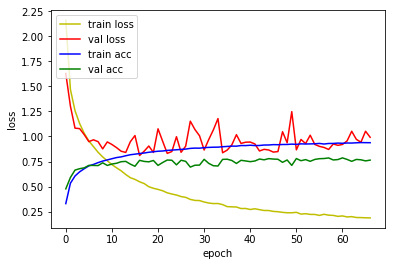

4815/4815 [==============================] - 4s 886us/sample - loss: 0.9074 - acc: 0.7277
Loss: 0.9074451053130169 Accuracy: 0.72772586

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4172 - acc: 0.2611
Epoch 00001: val_loss improved from inf to 1.73950, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_DO_BN_5_conv_checkpoint/001-1.7395.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 2.4171 - acc: 0.2611 - val_loss: 1.7395 - val_acc: 0.4274
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5803 - acc: 0.4891
Epoch 00002: val_loss improved from 1.73950 to 1.17258, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_DO_BN_5_conv_checkpoint/002-1.1726.hdf5
36805/36805 [==============================] - 84s 2ms/sample - loss: 1.5804 - acc: 0.4890 - val_loss: 1.1726 - val_acc: 0.6389
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s -

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5376 - acc: 0.8370
Epoch 00026: val_loss did not improve from 0.63098
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.5375 - acc: 0.8370 - val_loss: 0.6590 - val_acc: 0.8146
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5228 - acc: 0.8426
Epoch 00027: val_loss did not improve from 0.63098
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.5229 - acc: 0.8425 - val_loss: 0.6603 - val_acc: 0.8081
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5182 - acc: 0.8428
Epoch 00028: val_loss did not improve from 0.63098
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.5182 - acc: 0.8428 - val_loss: 0.6903 - val_acc: 0.7966
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5043 - acc: 0.8466
Epoch 00029: val_loss did not improve from 0.63098
36805/36805 [===========

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3627 - acc: 0.8881
Epoch 00055: val_loss did not improve from 0.56213
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.3627 - acc: 0.8881 - val_loss: 0.8469 - val_acc: 0.7715
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3618 - acc: 0.8864
Epoch 00056: val_loss did not improve from 0.56213
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.3618 - acc: 0.8863 - val_loss: 0.6522 - val_acc: 0.8185
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3593 - acc: 0.8869
Epoch 00057: val_loss did not improve from 0.56213
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.3596 - acc: 0.8869 - val_loss: 0.5894 - val_acc: 0.8393
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3596 - acc: 0.8868
Epoch 00058: val_loss did not improve from 0.56213
36805/36805 [===========

Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2744 - acc: 0.9119
Epoch 00085: val_loss did not improve from 0.56213
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.2743 - acc: 0.9119 - val_loss: 0.5667 - val_acc: 0.8519
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2761 - acc: 0.9111
Epoch 00086: val_loss did not improve from 0.56213
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.2761 - acc: 0.9111 - val_loss: 0.5834 - val_acc: 0.8549
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2705 - acc: 0.9127
Epoch 00087: val_loss did not improve from 0.56213
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.2704 - acc: 0.9128 - val_loss: 0.7279 - val_acc: 0.8132
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2699 - acc: 0.9123
Epoch 00088: val_loss did not improve from 0.56213
36805/36805 [===========

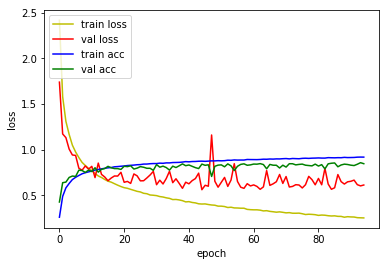

4815/4815 [==============================] - 4s 871us/sample - loss: 0.6616 - acc: 0.8075
Loss: 0.6616365684403314 Accuracy: 0.80747664

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.8050 - acc: 0.1719
Epoch 00001: val_loss improved from inf to 2.16316, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_DO_BN_6_conv_checkpoint/001-2.1632.hdf5
36805/36805 [==============================] - 93s 3ms/sample - loss: 2.8049 - acc: 0.1719 - val_loss: 2.1632 - val_acc: 0.3473
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9030 - acc: 0.3825
Epoch 00002: val_loss improved from 2.16316 to 1.35837, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_DO_BN_6_conv_checkpoint/002-1.3584.hdf5
36805/36805 [==============================] - 85s 2ms/sample - loss: 1.9030 - acc: 0.3826 - val_loss: 1.3584 - val_acc: 0.5851
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s -

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5465 - acc: 0.8376
Epoch 00024: val_loss did not improve from 0.53890
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.5467 - acc: 0.8375 - val_loss: 0.5522 - val_acc: 0.8435
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5382 - acc: 0.8423
Epoch 00025: val_loss did not improve from 0.53890
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.5382 - acc: 0.8423 - val_loss: 0.5453 - val_acc: 0.8512
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5313 - acc: 0.8444
Epoch 00026: val_loss did not improve from 0.53890
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.5313 - acc: 0.8444 - val_loss: 0.5808 - val_acc: 0.8339
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5114 - acc: 0.8482
Epoch 00027: val_loss improved from 0.53890 to 0.52366, saving model to mod

Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3760 - acc: 0.8873
Epoch 00052: val_loss did not improve from 0.43486
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.3760 - acc: 0.8873 - val_loss: 0.4358 - val_acc: 0.8791
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3724 - acc: 0.8887
Epoch 00053: val_loss did not improve from 0.43486
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.3725 - acc: 0.8887 - val_loss: 0.4775 - val_acc: 0.8670
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3672 - acc: 0.8871
Epoch 00054: val_loss improved from 0.43486 to 0.42394, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_DO_BN_6_conv_checkpoint/054-0.4239.hdf5
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.3673 - acc: 0.8871 - val_loss: 0.4239 - val_acc: 0.8931
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - lo

Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2952 - acc: 0.9099
Epoch 00080: val_loss did not improve from 0.40648
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.2952 - acc: 0.9099 - val_loss: 0.4065 - val_acc: 0.8966
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2947 - acc: 0.9084
Epoch 00081: val_loss improved from 0.40648 to 0.40462, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_DO_BN_6_conv_checkpoint/081-0.4046.hdf5
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.2951 - acc: 0.9083 - val_loss: 0.4046 - val_acc: 0.8977
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2976 - acc: 0.9088
Epoch 00082: val_loss did not improve from 0.40462
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.2977 - acc: 0.9087 - val_loss: 0.4128 - val_acc: 0.8935
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - lo

Epoch 108/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2462 - acc: 0.9233
Epoch 00108: val_loss did not improve from 0.37774
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.2463 - acc: 0.9233 - val_loss: 0.4915 - val_acc: 0.8677
Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2528 - acc: 0.9196
Epoch 00109: val_loss did not improve from 0.37774
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.2530 - acc: 0.9195 - val_loss: 0.4513 - val_acc: 0.8824
Epoch 110/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2502 - acc: 0.9215
Epoch 00110: val_loss did not improve from 0.37774
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.2502 - acc: 0.9216 - val_loss: 0.3941 - val_acc: 0.9045
Epoch 111/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2454 - acc: 0.9232
Epoch 00111: val_loss did not improve from 0.37774
36805/36805 [=======

36800/36805 [============================>.] - ETA: 0s - loss: 0.2165 - acc: 0.9318
Epoch 00137: val_loss did not improve from 0.37120
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.2165 - acc: 0.9318 - val_loss: 0.4998 - val_acc: 0.8742
Epoch 138/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2145 - acc: 0.9317
Epoch 00138: val_loss did not improve from 0.37120
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.2144 - acc: 0.9317 - val_loss: 0.4256 - val_acc: 0.8956
Epoch 139/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2063 - acc: 0.9347
Epoch 00139: val_loss did not improve from 0.37120
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.2066 - acc: 0.9346 - val_loss: 0.3961 - val_acc: 0.9043
Epoch 140/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2117 - acc: 0.9335
Epoch 00140: val_loss did not improve from 0.37120
36805/36805 [=====================

Epoch 167/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1900 - acc: 0.9386
Epoch 00167: val_loss did not improve from 0.37120
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.1901 - acc: 0.9385 - val_loss: 0.4159 - val_acc: 0.9010
Epoch 168/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1863 - acc: 0.9395
Epoch 00168: val_loss did not improve from 0.37120
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.1867 - acc: 0.9394 - val_loss: 0.4292 - val_acc: 0.9045
Epoch 169/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1844 - acc: 0.9421
Epoch 00169: val_loss did not improve from 0.37120
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.1844 - acc: 0.9422 - val_loss: 0.4144 - val_acc: 0.8982
Epoch 170/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1810 - acc: 0.9414
Epoch 00170: val_loss did not improve from 0.37120
36805/36805 [=======

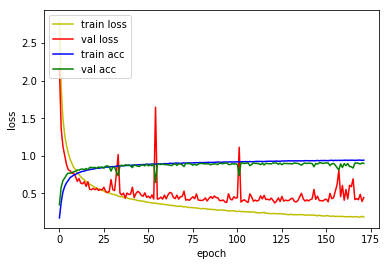

4815/4815 [==============================] - 4s 876us/sample - loss: 0.4401 - acc: 0.8766
Loss: 0.44006399147730874 Accuracy: 0.8766355

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.1166 - acc: 0.0966
Epoch 00001: val_loss improved from inf to 2.54271, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_DO_BN_7_conv_checkpoint/001-2.5427.hdf5
36805/36805 [==============================] - 95s 3ms/sample - loss: 3.1164 - acc: 0.0966 - val_loss: 2.5427 - val_acc: 0.1740
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5054 - acc: 0.2032
Epoch 00002: val_loss improved from 2.54271 to 1.97185, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_DO_BN_7_conv_checkpoint/002-1.9718.hdf5
36805/36805 [==============================] - 85s 2ms/sample - loss: 2.5053 - acc: 0.2032 - val_loss: 1.9718 - val_acc: 0.3993
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s -

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6408 - acc: 0.8085
Epoch 00024: val_loss improved from 0.50766 to 0.48764, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_DO_BN_7_conv_checkpoint/024-0.4876.hdf5
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.6408 - acc: 0.8084 - val_loss: 0.4876 - val_acc: 0.8663
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6279 - acc: 0.8118
Epoch 00025: val_loss improved from 0.48764 to 0.47069, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_DO_BN_7_conv_checkpoint/025-0.4707.hdf5
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.6280 - acc: 0.8118 - val_loss: 0.4707 - val_acc: 0.8786
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6198 - acc: 0.8161
Epoch 00026: val_loss improved from 0.47069 to 0.46095, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_DO_BN_7_conv_checkpoint/026-0.4610.hdf5


Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4468 - acc: 0.8651
Epoch 00051: val_loss did not improve from 0.34787
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.4469 - acc: 0.8650 - val_loss: 0.3719 - val_acc: 0.9082
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4375 - acc: 0.8672
Epoch 00052: val_loss did not improve from 0.34787
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.4375 - acc: 0.8672 - val_loss: 0.4218 - val_acc: 0.8800
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4260 - acc: 0.8705
Epoch 00053: val_loss did not improve from 0.34787
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.4260 - acc: 0.8705 - val_loss: 0.3518 - val_acc: 0.9059
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4232 - acc: 0.8720
Epoch 00054: val_loss did not improve from 0.34787
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.3456 - acc: 0.8936
Epoch 00079: val_loss did not improve from 0.31574
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.3455 - acc: 0.8936 - val_loss: 0.3252 - val_acc: 0.9189
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3459 - acc: 0.8924
Epoch 00080: val_loss did not improve from 0.31574
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.3459 - acc: 0.8924 - val_loss: 0.3332 - val_acc: 0.9175
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3498 - acc: 0.8915
Epoch 00081: val_loss did not improve from 0.31574
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.3497 - acc: 0.8915 - val_loss: 0.3438 - val_acc: 0.9143
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3394 - acc: 0.8930
Epoch 00082: val_loss did not improve from 0.31574
36805/36805 [========================

Epoch 108/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2928 - acc: 0.9104
Epoch 00108: val_loss did not improve from 0.28987
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.2929 - acc: 0.9103 - val_loss: 0.3119 - val_acc: 0.9224
Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2989 - acc: 0.9060
Epoch 00109: val_loss did not improve from 0.28987
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.2989 - acc: 0.9060 - val_loss: 0.3308 - val_acc: 0.9203
Epoch 110/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2847 - acc: 0.9107
Epoch 00110: val_loss did not improve from 0.28987
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.2850 - acc: 0.9106 - val_loss: 0.2939 - val_acc: 0.9262
Epoch 111/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2943 - acc: 0.9078
Epoch 00111: val_loss did not improve from 0.28987
36805/36805 [=======

36800/36805 [============================>.] - ETA: 0s - loss: 0.2505 - acc: 0.9212
Epoch 00137: val_loss did not improve from 0.28266
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.2504 - acc: 0.9213 - val_loss: 0.2892 - val_acc: 0.9273
Epoch 138/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2534 - acc: 0.9187
Epoch 00138: val_loss did not improve from 0.28266
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.2534 - acc: 0.9187 - val_loss: 0.3031 - val_acc: 0.9324
Epoch 139/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2474 - acc: 0.9201
Epoch 00139: val_loss did not improve from 0.28266
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.2475 - acc: 0.9201 - val_loss: 0.3047 - val_acc: 0.9252
Epoch 140/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2505 - acc: 0.9196
Epoch 00140: val_loss did not improve from 0.28266
36805/36805 [=====================

36800/36805 [============================>.] - ETA: 0s - loss: 0.2245 - acc: 0.9265
Epoch 00166: val_loss did not improve from 0.28126
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.2248 - acc: 0.9265 - val_loss: 0.3184 - val_acc: 0.9241
Epoch 167/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2263 - acc: 0.9279
Epoch 00167: val_loss did not improve from 0.28126
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.2265 - acc: 0.9278 - val_loss: 0.3047 - val_acc: 0.9245
Epoch 168/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2241 - acc: 0.9274
Epoch 00168: val_loss did not improve from 0.28126
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.2243 - acc: 0.9273 - val_loss: 0.3041 - val_acc: 0.9304
Epoch 169/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2220 - acc: 0.9289
Epoch 00169: val_loss did not improve from 0.28126
36805/36805 [=====================

Epoch 196/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2076 - acc: 0.9324
Epoch 00196: val_loss did not improve from 0.28126
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.2078 - acc: 0.9323 - val_loss: 0.3101 - val_acc: 0.9243
Epoch 197/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1982 - acc: 0.9354
Epoch 00197: val_loss did not improve from 0.28126
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.1982 - acc: 0.9354 - val_loss: 0.3302 - val_acc: 0.9331
Epoch 198/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1946 - acc: 0.9362
Epoch 00198: val_loss did not improve from 0.28126
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.1946 - acc: 0.9363 - val_loss: 0.3257 - val_acc: 0.9217
Epoch 199/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1949 - acc: 0.9374
Epoch 00199: val_loss did not improve from 0.28126
36805/36805 [=======

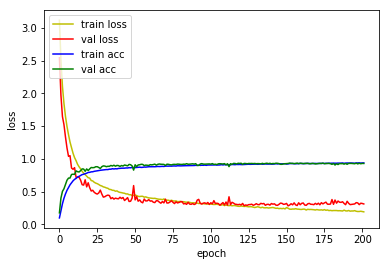

4815/4815 [==============================] - 4s 933us/sample - loss: 0.3134 - acc: 0.9128
Loss: 0.3134123099741535 Accuracy: 0.9127726

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.1916 - acc: 0.1076
Epoch 00001: val_loss improved from inf to 2.52090, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_DO_BN_8_conv_checkpoint/001-2.5209.hdf5
36805/36805 [==============================] - 100s 3ms/sample - loss: 3.1916 - acc: 0.1076 - val_loss: 2.5209 - val_acc: 0.1866
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6136 - acc: 0.1793
Epoch 00002: val_loss improved from 2.52090 to 2.14385, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_DO_BN_8_conv_checkpoint/002-2.1439.hdf5
36805/36805 [==============================] - 87s 2ms/sample - loss: 2.6137 - acc: 0.1792 - val_loss: 2.1439 - val_acc: 0.3343
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s -

36800/36805 [============================>.] - ETA: 0s - loss: 0.7460 - acc: 0.7716
Epoch 00023: val_loss did not improve from 0.51091
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.7462 - acc: 0.7716 - val_loss: 0.5211 - val_acc: 0.8565
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7279 - acc: 0.7760
Epoch 00024: val_loss did not improve from 0.51091
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.7280 - acc: 0.7760 - val_loss: 0.5405 - val_acc: 0.8484
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7019 - acc: 0.7871
Epoch 00025: val_loss improved from 0.51091 to 0.49052, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_DO_BN_8_conv_checkpoint/025-0.4905.hdf5
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.7018 - acc: 0.7871 - val_loss: 0.4905 - val_acc: 0.8658
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6863 - 

36800/36805 [============================>.] - ETA: 0s - loss: 0.4664 - acc: 0.8586
Epoch 00049: val_loss did not improve from 0.33848
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.4664 - acc: 0.8586 - val_loss: 0.3625 - val_acc: 0.9026
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4577 - acc: 0.8600
Epoch 00050: val_loss improved from 0.33848 to 0.33023, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_DO_BN_8_conv_checkpoint/050-0.3302.hdf5
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.4580 - acc: 0.8600 - val_loss: 0.3302 - val_acc: 0.9115
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4483 - acc: 0.8639
Epoch 00051: val_loss did not improve from 0.33023
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.4483 - acc: 0.8639 - val_loss: 0.3924 - val_acc: 0.8877
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4460 - 

Epoch 77/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3507 - acc: 0.8920
Epoch 00077: val_loss did not improve from 0.27066
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.3508 - acc: 0.8919 - val_loss: 0.2824 - val_acc: 0.9248
Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3483 - acc: 0.8937
Epoch 00078: val_loss did not improve from 0.27066
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.3483 - acc: 0.8937 - val_loss: 0.2809 - val_acc: 0.9224
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3455 - acc: 0.8940
Epoch 00079: val_loss improved from 0.27066 to 0.24985, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_DO_BN_8_conv_checkpoint/079-0.2498.hdf5
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.3455 - acc: 0.8940 - val_loss: 0.2498 - val_acc: 0.9320
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - lo

Epoch 106/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2903 - acc: 0.9094
Epoch 00106: val_loss did not improve from 0.24339
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.2902 - acc: 0.9094 - val_loss: 0.2446 - val_acc: 0.9317
Epoch 107/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2920 - acc: 0.9093
Epoch 00107: val_loss did not improve from 0.24339
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.2922 - acc: 0.9093 - val_loss: 0.2492 - val_acc: 0.9315
Epoch 108/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2895 - acc: 0.9093
Epoch 00108: val_loss did not improve from 0.24339
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.2894 - acc: 0.9093 - val_loss: 0.2757 - val_acc: 0.9255
Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2814 - acc: 0.9124
Epoch 00109: val_loss did not improve from 0.24339
36805/36805 [=======

Epoch 135/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2469 - acc: 0.9208
Epoch 00135: val_loss did not improve from 0.24240
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.2470 - acc: 0.9207 - val_loss: 0.2732 - val_acc: 0.9313
Epoch 136/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2488 - acc: 0.9198
Epoch 00136: val_loss did not improve from 0.24240
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.2488 - acc: 0.9198 - val_loss: 0.2641 - val_acc: 0.9338
Epoch 137/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2416 - acc: 0.9209
Epoch 00137: val_loss did not improve from 0.24240
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.2416 - acc: 0.9209 - val_loss: 0.2535 - val_acc: 0.9373
Epoch 138/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2417 - acc: 0.9233
Epoch 00138: val_loss did not improve from 0.24240
36805/36805 [=======

36800/36805 [============================>.] - ETA: 0s - loss: 0.2180 - acc: 0.9290
Epoch 00164: val_loss did not improve from 0.23472
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.2183 - acc: 0.9289 - val_loss: 0.2673 - val_acc: 0.9299
Epoch 165/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2201 - acc: 0.9283
Epoch 00165: val_loss did not improve from 0.23472
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.2201 - acc: 0.9283 - val_loss: 0.3019 - val_acc: 0.9229
Epoch 166/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2092 - acc: 0.9322
Epoch 00166: val_loss did not improve from 0.23472
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.2092 - acc: 0.9322 - val_loss: 0.2565 - val_acc: 0.9329
Epoch 167/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2099 - acc: 0.9312
Epoch 00167: val_loss did not improve from 0.23472
36805/36805 [=====================

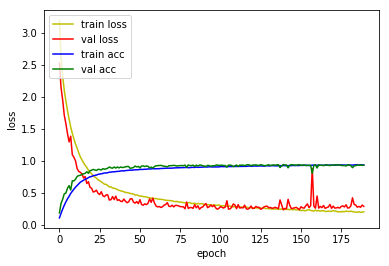

4815/4815 [==============================] - 5s 952us/sample - loss: 0.2910 - acc: 0.9223
Loss: 0.29099333845194997 Accuracy: 0.9223261

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.0382 - acc: 0.1008
Epoch 00001: val_loss improved from inf to 2.55993, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_DO_BN_9_conv_checkpoint/001-2.5599.hdf5
36805/36805 [==============================] - 106s 3ms/sample - loss: 3.0381 - acc: 0.1008 - val_loss: 2.5599 - val_acc: 0.1882
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5121 - acc: 0.1876
Epoch 00002: val_loss improved from 2.55993 to 2.10775, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_DO_BN_9_conv_checkpoint/002-2.1078.hdf5
36805/36805 [==============================] - 88s 2ms/sample - loss: 2.5120 - acc: 0.1876 - val_loss: 2.1078 - val_acc: 0.3692
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s 

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8337 - acc: 0.7349
Epoch 00023: val_loss improved from 0.51691 to 0.50968, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_DO_BN_9_conv_checkpoint/023-0.5097.hdf5
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.8337 - acc: 0.7349 - val_loss: 0.5097 - val_acc: 0.8663
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8175 - acc: 0.7390
Epoch 00024: val_loss improved from 0.50968 to 0.47208, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_DO_BN_9_conv_checkpoint/024-0.4721.hdf5
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.8175 - acc: 0.7390 - val_loss: 0.4721 - val_acc: 0.8775
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7942 - acc: 0.7436
Epoch 00025: val_loss improved from 0.47208 to 0.47011, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_DO_BN_9_conv_checkpoint/025-0.4701.hdf5


Epoch 48/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5333 - acc: 0.8317
Epoch 00048: val_loss improved from 0.29700 to 0.29132, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_DO_BN_9_conv_checkpoint/048-0.2913.hdf5
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.5335 - acc: 0.8317 - val_loss: 0.2913 - val_acc: 0.9161
Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5290 - acc: 0.8306
Epoch 00049: val_loss did not improve from 0.29132
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.5290 - acc: 0.8306 - val_loss: 0.2979 - val_acc: 0.9182
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5264 - acc: 0.8320
Epoch 00050: val_loss did not improve from 0.29132
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.5267 - acc: 0.8319 - val_loss: 0.3042 - val_acc: 0.9154
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - lo

Epoch 75/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4088 - acc: 0.8685
Epoch 00075: val_loss did not improve from 0.24666
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.4092 - acc: 0.8684 - val_loss: 0.2513 - val_acc: 0.9308
Epoch 76/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4058 - acc: 0.8711
Epoch 00076: val_loss did not improve from 0.24666
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.4059 - acc: 0.8711 - val_loss: 0.2641 - val_acc: 0.9273
Epoch 77/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4017 - acc: 0.8711
Epoch 00077: val_loss did not improve from 0.24666
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.4018 - acc: 0.8711 - val_loss: 0.2560 - val_acc: 0.9276
Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3967 - acc: 0.8705
Epoch 00078: val_loss did not improve from 0.24666
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.3300 - acc: 0.8902
Epoch 00104: val_loss did not improve from 0.24622
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.3314 - acc: 0.8901 - val_loss: 0.2596 - val_acc: 0.9329
Epoch 105/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3484 - acc: 0.8846
Epoch 00105: val_loss did not improve from 0.24622
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.3486 - acc: 0.8846 - val_loss: 0.2633 - val_acc: 0.9304
Epoch 106/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3361 - acc: 0.8899
Epoch 00106: val_loss did not improve from 0.24622
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.3361 - acc: 0.8899 - val_loss: 0.2515 - val_acc: 0.9350
Epoch 107/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3262 - acc: 0.8927
Epoch 00107: val_loss did not improve from 0.24622
36805/36805 [=====================

36800/36805 [============================>.] - ETA: 0s - loss: 0.2856 - acc: 0.9045
Epoch 00133: val_loss did not improve from 0.23419
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.2855 - acc: 0.9045 - val_loss: 0.2623 - val_acc: 0.9338
Epoch 134/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2911 - acc: 0.9014
Epoch 00134: val_loss did not improve from 0.23419
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.2910 - acc: 0.9014 - val_loss: 0.2575 - val_acc: 0.9350
Epoch 135/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2810 - acc: 0.9054
Epoch 00135: val_loss did not improve from 0.23419
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.2812 - acc: 0.9054 - val_loss: 0.2673 - val_acc: 0.9371
Epoch 136/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2927 - acc: 0.9040
Epoch 00136: val_loss did not improve from 0.23419
36805/36805 [=====================

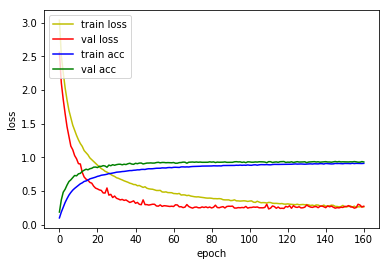

4815/4815 [==============================] - 5s 984us/sample - loss: 0.3284 - acc: 0.9094
Loss: 0.32841336481420175 Accuracy: 0.90944964



In [10]:
for i in range(4, 10):
    base = '1D_CNN_custom_4_ch_64_DO_BN'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_DO_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_4_ch_64_DO_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(4, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_4_ch_64_DO_BN_4_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_45 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_46 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_46 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.4401 - acc: 0.8766
Loss: 0.44006399147730874 Accuracy: 0.8766355

1D_CNN_custom_4_ch_64_DO_BN_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_60 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_60 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_60 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_61 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_61 (Activation)   (No

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2910 - acc: 0.9223
Loss: 0.29099333845194997 Accuracy: 0.9223261

1D_CNN_custom_4_ch_64_DO_BN_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_75 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_75 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_75 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_76 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_76 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_76 (Activation)   (No

In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(4, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_4_ch_64_DO_BN_4_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_45 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_46 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_46 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.4827 - acc: 0.8754
Loss: 0.48269676133479655 Accuracy: 0.8753894

1D_CNN_custom_4_ch_64_DO_BN_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_60 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_60 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_60 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_61 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_61 (Activation)   (No

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.3136 - acc: 0.9184
Loss: 0.31362761453428495 Accuracy: 0.9183801

1D_CNN_custom_4_ch_64_DO_BN_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_75 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_75 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_75 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_76 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_76 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_76 (Activation)   (No